# Non-linear Matrix Factorization with Gaussian Processes

This is an attempt to reproduce [this ICML 2009 paper](http://people.ee.duke.edu/~lcarin/MatrixFactorization.pdf).

In [1]:
import tensorflow as tf
DEVICE = "/cpu:0"

In [2]:
from collections import Counter

In [3]:
N = 100  # items
D = 2071  # users
q = 10  # latent dimension

In [4]:
# Simulated data
import numpy as np
from sklearn.preprocessing import scale

def get_simulated_data(true_alpha_x=5, true_alpha_w=2, true_sigma=1):
    X = np.random.randint(50, size=(N, q))
    #X = np.random.normal(0, 1/true_alpha_x, (N, q))
    W = np.random.normal(0, 1/true_alpha_w, (D, q))
    rating_rows = []
    for i in range(N):
        rating_rows.append(np.random.multivariate_normal(W.dot(X[i, :]), true_sigma ** 2 * np.eye(D)))
    Y = np.array(rating_rows)
    Y_scaled = scale(Y, axis=1, with_std=False)
    return Y, Y_scaled

In [5]:
rating_values = {'dislike': 1, 'wontsee': 2, 'neutral': 3, 'willsee': 4, 'like': 5, 'favorite': 6}

In [6]:
# Real data
from mangaki.algo.dataset import Dataset
#from mangaki.utils.values import rating_values

dataset = Dataset()
dataset.load_csv('ratings-ordered.csv', convert=lambda choice: rating_values[choice])

In [7]:
from scipy.sparse import coo_matrix

rows = dataset.anonymized.X[:, 0]
cols = dataset.anonymized.X[:, 1]
data = dataset.anonymized.y
mangaki = coo_matrix((data, (rows, cols)), shape=(dataset.anonymized.nb_users, dataset.anonymized.nb_works)).tocsr()

In [8]:
from collections import defaultdict

inverter = defaultdict(list)
for user_id in range(D):
    batch = mangaki[user_id, :]
    c = Counter(batch.data)
    inverter[tuple(c[rating_values[rating]] for rating in ['dislike', 'favorite', 'like', 'neutral', 'willsee', 'wontsee'])].append(user_id)

In [9]:
inverter[16, 23, 118, 9, 330, 68]

[162]

In [10]:
mangaki

<2071x10086 sparse matrix of type '<class 'numpy.float64'>'
	with 333647 stored elements in Compressed Sparse Row format>

Now skip to ALS.

In [132]:
mangaki[:, :100]

<2071x100 sparse matrix of type '<class 'numpy.float64'>'
	with 78195 stored elements in Compressed Sparse Row format>

In [133]:
Y = mangaki[:, :100].tocoo().T.tocsr()
for movie_id in range(N):
    row = Y[movie_id, :]
    for user_id, replace in zip(row.indices, scale(row.data)):
        Y[movie_id, user_id] = replace

In [134]:
dataset = coo_matrix(Y)
#dataset = coo_matrix(Y_scaled)

In [135]:
Y

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 78195 stored elements in Compressed Sparse Row format>

In [136]:
# Prepare batches
from sklearn.model_selection import ShuffleSplit

# Simple split
splitter = ShuffleSplit(n_splits=1, test_size=0.2)
for i_train, i_test in splitter.split(dataset.data):
    train = coo_matrix((dataset.data[i_train], (dataset.row[i_train], dataset.col[i_train])), shape=(N, D)).tocsc()
    test = coo_matrix((dataset.data[i_test], (dataset.row[i_test], dataset.col[i_test])), shape=(N, D)).tocsc()

# Split by user
train_data = []
train_row = []
train_col = []
test_data = []
test_row = []
test_col = []
full = dataset.tocsc()
nb_skip = 0
train_users = set(range(D))
for user_id in range(D):
    this_user = full[:, user_id]
    N_j = this_user.getnnz()
    if N_j <= q:
        train_users.remove(user_id)
        nb_skip += 1
        continue
    for i_train, i_test in splitter.split(this_user.indices):
        train_col.extend([user_id] * len(i_train))
        train_row.extend(this_user.indices[i_train])
        train_data.extend(this_user.data[i_train])
        test_col.extend([user_id] * len(i_test))
        test_row.extend(this_user.indices[i_test])
        test_data.extend(this_user.data[i_test])
print('nb users skipped', nb_skip, 'over', D)

nb users skipped 465 over 2071


In [137]:
assert len(train_data) == len(train_row)
assert len(test_data) == len(test_row)

In [138]:
train = coo_matrix((train_data, (train_row, train_col)), shape=(N, D)).tocsc()
test = coo_matrix((test_data, (test_row, test_col)), shape=(N, D)).tocsc()

In [139]:
train

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 60093 stored elements in Compressed Sparse Column format>

In [140]:
test

<100x2071 sparse matrix of type '<class 'numpy.float64'>'
	with 15842 stored elements in Compressed Sparse Column format>

In [141]:
item_batch = tf.placeholder(tf.int32, shape=[None], name="id_item")
rate_batch = tf.placeholder(tf.float32, shape=[None, None], name="rate")
pred_batch = tf.placeholder(tf.int32, shape=[None], name="id_pred")

In [142]:
def log_det(cov):
    return 2 * tf.reduce_sum(tf.log(tf.diag_part(tf.cholesky(cov))))

In [146]:
def kernel(X, Y):
    return tf.matmul(X, tf.transpose(Y))

class MFGP:
    def __init__(self):
        with tf.device(DEVICE):
            with tf.variable_scope("conv1"):
                self.sigma = tf.Variable(1e-1, name="sigma")  # tf.random_normal([1])
                self.alpha_w = tf.Variable(tf.random_normal([1]), name="alpha_w")
                self.X_item = tf.Variable(tf.random_normal([N, q], stddev=5), name="embd_item")

    def predict(self, item_batch, rate_batch, pred_batch):
        with tf.device(DEVICE):
            X_batch = tf.nn.embedding_lookup(self.X_item, item_batch)
            X_pred = tf.nn.embedding_lookup(self.X_item, pred_batch)
            N_j = tf.shape(item_batch)[0]
            cov = kernel(X_batch, X_batch) + self.sigma ** 2 * tf.eye(N_j)
            s = tf.matmul(tf.matrix_inverse(cov), kernel(X_batch, X_pred))
            prediction = tf.matmul(tf.transpose(s), rate_batch)
        return tf.reshape(prediction, [-1])

    def get_loss(self, item_batch, rate_batch):
        with tf.device(DEVICE):
            X_batch = tf.nn.embedding_lookup(self.X_item, item_batch)
            XT_batch = tf.transpose(X_batch)
            N_j = tf.shape(item_batch)[0]
            defpos = kernel(X_batch, X_batch)
            cov = 1/tf.abs(self.alpha_w) * defpos + self.sigma ** 2 * tf.eye(N_j)
            # inv_cov = tf.matrix_inverse(cov)  # O(N_j^3)
            cheap_inv = tf.matrix_inverse(tf.abs(self.alpha_w) * self.sigma ** (-2) * tf.eye(q)
                                          + tf.matmul(XT_batch, X_batch))
            inv_cov = self.sigma ** (-2) - self.sigma ** (-4) * tf.matmul(X_batch, tf.matmul(cheap_inv, XT_batch))  # O(q^3)
            loss = (tf.cast(N_j, tf.float32) * log_det(cov)
                    + tf.reshape(tf.matmul(tf.transpose(rate_batch), tf.matmul(inv_cov, rate_batch)), []))
        return loss, (cov, defpos, X_batch)

    def optimization(self, item_batch, rate_batch, learning_rate):
        global_step = tf.train.get_global_step()
        assert global_step is not None
        with tf.device(DEVICE):
            loss, (cov, defpos, X_batch) = self.get_loss(item_batch, rate_batch)
            train_op = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True).minimize(loss, global_step=global_step, var_list=[self.X_item])
        return loss, train_op, (cov, defpos, X_batch)

In [147]:
def to_matrix(l):
    return np.array(l).reshape(len(l), 1)

In [148]:
from sklearn.metrics import mean_squared_error
from collections import deque
import time
import random
import sys

mfgp = MFGP()
prediction = mfgp.predict(item_batch, rate_batch, pred_batch)

global_step = tf.contrib.framework.get_or_create_global_step()
loss, train_op, (cov, defpos, X_batch) = mfgp.optimization(item_batch, rate_batch, learning_rate=0.0001)

init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    print(" | ".join(["user_id", "epoch", "train_error", "val_error", "elapsed_time"]))
    errors = []
    for epoch in range(50):
        cross = list(train_users)
        random.shuffle(cross)
        train_preds = []
        train_ratings = []
        for user_id in cross:
            train_batch = train[:, user_id]
            if train_batch.getnnz() == 0:
                continue
            items_rated, ratings = train_batch.indices, to_matrix(train_batch.data)
            try:
                sess.run(train_op, feed_dict={item_batch: items_rated,
                                              rate_batch: ratings,
                                              pred_batch: items_rated})
            except Exception as e:
                print('Error for %d (%s): %s' % (user_id, str(items_rated), sys.exc_info()[0]))
                print('Sigma', mfgp.sigma.eval(), 'alpha_w', mfgp.alpha_w.eval())
                print(sess.run([tf.shape(X_batch), X_batch], feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(sess.run(tf.matrix_determinant(defpos), feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(sess.run(tf.matrix_determinant(cov), feed_dict={item_batch: items_rated, rate_batch: ratings, pred_batch: items_rated}))
                print(e.message)
                print(sys.exc_info()[0].__doc__)

        # End of train epoch, start test
        if epoch % 1 == 0:
            total_nll = []
            test_truth = []
            test_preds = []
            for user_id in train_users:
                train_batch = train[:, user_id]
                test_batch = test[:, user_id]
                items_rated, ratings = train_batch.indices, to_matrix(train_batch.data)
                items_to_pred, truth = test_batch.indices, test_batch.data
                try:
                    this_user_nll, train_pred = sess.run([loss, prediction], feed_dict={item_batch: items_rated,
                                                                                        rate_batch: ratings,
                                                                                        pred_batch: items_rated})
                except:
                    print('Error for train %d (%s): %s' % (user_id, str(items_rated), sys.exc_info()[0]))
                try:
                    test_pred = sess.run(prediction, feed_dict={item_batch: items_rated,
                                                                rate_batch: ratings,
                                                                pred_batch: items_to_pred})
                except:
                    print('Error for test %d (%s): %s' % (user_id, str(items_to_pred), sys.exc_info()[0]))
                total_nll.append(this_user_nll)
                train_ratings.extend(ratings)
                train_preds.extend(train_pred)
                test_truth.extend(truth)
                test_preds.extend(test_pred)
            train_rmse = np.sqrt(mean_squared_error(train_ratings, train_preds))            
            train_stupid = np.sqrt(mean_squared_error(train_ratings, [0] * len(train_ratings)))            
            test_rmse = np.sqrt(mean_squared_error(test_truth, test_preds))
            test_stupid = np.sqrt(mean_squared_error(test_truth, [0] * len(test_truth)))
            print("epoch={:3d} train_rmse={:f} ({:f}) test_rmse={:f} ({:f}) total_nll={:f} sigma={:f} alpha_w={:f}"
                  .format(epoch, train_rmse, train_stupid, test_rmse, test_stupid,
                          sum(total_nll), abs(float(mfgp.sigma.eval())), abs(float(mfgp.alpha_w.eval()))))
    print('learned sigma')
    print(mfgp.sigma.eval())
    print('learned alpha_w')
    print(mfgp.alpha_w.eval())
    print('learned x')
    print(mfgp.x_item.eval())

user_id | epoch | train_error | val_error | elapsed_time
epoch=  0 train_rmse=7.099235 (1.000710) test_rmse=6.157351 (1.003259) total_nll=-287224265.353516 sigma=0.100000 alpha_w=1.753959
epoch=  1 train_rmse=2.079178 (1.000710) test_rmse=2.118881 (1.003259) total_nll=-298726846.699219 sigma=0.100000 alpha_w=1.753959
epoch=  2 train_rmse=11.680286 (1.000710) test_rmse=9.852969 (1.003259) total_nll=-302750440.118164 sigma=0.100000 alpha_w=1.753959
epoch=  3 train_rmse=19.395447 (1.000710) test_rmse=15.919051 (1.003259) total_nll=-304895133.985352 sigma=0.100000 alpha_w=1.753959
epoch=  4 train_rmse=27.530071 (1.000710) test_rmse=28.348537 (1.003259) total_nll=-306099596.312500 sigma=0.100000 alpha_w=1.753959
epoch=  5 train_rmse=9.603479 (1.000710) test_rmse=9.229228 (1.003259) total_nll=-307085520.960938 sigma=0.100000 alpha_w=1.753959


KeyboardInterrupt: 

(The error is because it was interrupted.)

As you can see, the learning stops when the stupid RMSE (every prediction is 0) is obtained.

# Meanwhile, Alternating Least Squares…

In [11]:
mangaki

<2071x10086 sparse matrix of type '<class 'numpy.float64'>'
	with 333647 stored elements in Compressed Sparse Row format>

In [12]:
mangaki.data[:10]

array([ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  3.,  5.,  3.])

In [13]:
from sklearn.model_selection import ShuffleSplit

splitter = ShuffleSplit(n_splits=1, test_size=0.2)
X_train = []
y_train = []
X_test = []
y_test = []
for i_train, i_test in splitter.split(range(D)):
    i_train = set(i_train)
    i_test = set(i_test)
    for (user_id, work_id), rating in zip(dataset.anonymized.X, dataset.anonymized.y):
        if user_id in i_train:
            X_train.append((user_id, work_id))
            y_train.append(rating)
        else:
            X_test.append((user_id, work_id))
            y_test.append(rating)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [14]:
len(X_train), len(X_test)

(269096, 64551)

In [15]:
from mangaki.algo.als import MangakiALS

def compute_all_errors(X_train, y_train, X_test, y_test):
    y_train_pred = als.predict(X_train)
    print('Train RMSE=', als.compute_rmse(y_train, y_train_pred))
    y_test_pred = als.predict(X_test)
    print('Test RMSE=', als.compute_rmse(y_test, y_test_pred))

als = MangakiALS()
als.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
als.fit(X_train, y_train)
compute_all_errors(X_train, y_train, X_test, y_test)

Computing M: (2071 × 10086)
Chrono: fill and center matrix [0q, 851ms]
Shapes (2071, 20) (20, 10086)
Chrono: factor matrix [0q, 6203ms]
Train RMSE= 0.908685007485
Test RMSE= 3.88622254089


In [16]:
y_pred = als.predict(X_train)
(y_train - y_pred).std()

0.90864098884273259

And the learned rows of $U$ seem Gaussian!

(array([   5.,   29.,  128.,  300.,  459.,  622.,  263.,  144.,  114.,    7.]),
 array([-1.35755361, -1.09632291, -0.83509222, -0.57386153, -0.31263083,
        -0.05140014,  0.20983055,  0.47106125,  0.73229194,  0.99352263,
         1.25475333]),
 <a list of 10 Patch objects>)

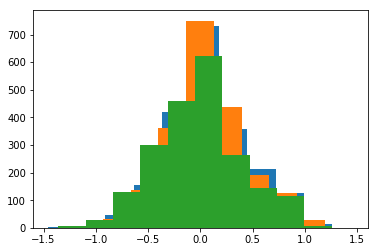

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(als.U[:, 0])
plt.hist(als.U[:, 1])
plt.hist(als.U[:, 15])

(array([  3.00000000e+00,   2.40000000e+01,   8.20000000e+01,
          4.11000000e+02,   1.26200000e+03,   3.28300000e+03,
          3.26900000e+03,   1.25500000e+03,   3.84000000e+02,
          1.13000000e+02]),
 array([-1.77896011, -1.48677032, -1.19458054, -0.90239076, -0.61020098,
        -0.31801119, -0.02582141,  0.26636837,  0.55855816,  0.85074794,
         1.14293772]),
 <a list of 10 Patch objects>)

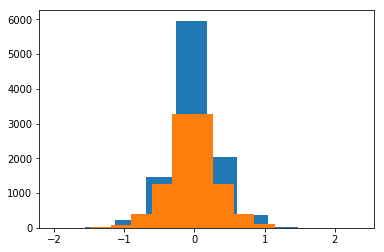

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(als.VT.T[:, 17])
plt.hist(als.VT.T[:, 5])

Maybe it does not hold for $V$.

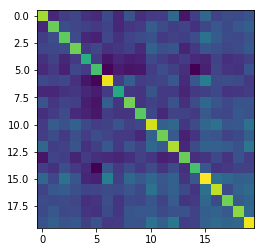

In [19]:
%matplotlib inline

cov = np.cov(als.U.T)
plt.imshow(cov)

In [450]:
np.diag(cov)

array([ 0.11707712,  0.14089718,  0.1350106 ,  0.17112492,  0.12726649,
        0.13786349,  0.12069726,  0.13820964,  0.13952311,  0.12396863,
        0.13126928,  0.14719841,  0.1306917 ,  0.14697602,  0.11287327,
        0.12292174,  0.12599884,  0.14341246,  0.11476866,  0.14017763])

In [451]:
als.U.shape

(2071, 20)

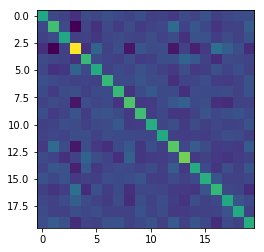

In [452]:
%matplotlib inline

cov = np.cov(als.VT)
plt.imshow(cov)

In [453]:
np.diag(cov)

array([ 0.08330251,  0.10214039,  0.08350031,  0.15950547,  0.09780134,
        0.08589314,  0.09690305,  0.09711807,  0.10683352,  0.10075043,
        0.0875443 ,  0.08529713,  0.11013919,  0.11939271,  0.08625146,
        0.08941918,  0.09596199,  0.08483713,  0.08513451,  0.08763338])

Learned components are independent.

In [454]:
als.means.mean()  # Global bias

3.2349312572334692

In [455]:
162 in i_test

False

In [33]:
PIG = list(i_test)[55]
# 162=JJ
pig = mangaki[PIG, :]
all_ratings = pig.data
all_ratings -= als.means.mean()
pig.getnnz()

107

In [34]:
pig.indices[:40]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 21, 22, 23, 24, 25, 29, 30, 31, 32, 33, 34, 35, 36, 38,
       39, 40, 42, 44, 46, 48], dtype=int32)

In [35]:
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression

kernel = 0.9 * DotProduct(sigma_0=1.)  # Kernel that will be used for both GP and DPP
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.9)  # 
lr = LinearRegression()

In [36]:
work_ids = pig.indices[START_PRED:]
user_ids = [PIG] * len(work_ids)
y_pred = als.predict(np.column_stack((user_ids, work_ids)))
mean_squared_error(pig.data[START_PRED:], y_pred) ** 0.5

1.7620890663665347

In [37]:
work_ids = pig.indices
ratings = pig.data
lr.fit(als.VT.T[work_ids], ratings)
y_pred = lr.predict(als.VT.T[work_ids])
mean_squared_error(pig.data, y_pred) ** 0.5

1.2046826844606242

In [38]:
pig.data[:5], y_pred[:5]

(array([ 1.78966434,  1.78966434,  2.78966434,  2.78966434,  1.78966434]),
 array([ 1.61990599,  2.82506166,  2.55215949,  1.76180029,  2.40277753]))

stupid 1.87650815509
5 rmse 2.08771217959
eigenvalues 1.05572296869 to 2.34834977568
alpha max 0.757998045927
[ 2.10745511  2.10745413  2.10746746  2.1074661   2.10746636] [ 1.78966434  1.78966434  2.78966434  2.78966434  1.78966434]
5 rmse 2.5281232503
10 rmse 1.58507343774
eigenvalues 1.23517605747 to 2.02407036877
alpha max 0.783694912301
[ 1.81613349  1.75819334  2.10052651  2.08433892  2.22014324] [ 1.78966434  1.78966434  2.78966434  2.78966434  1.78966434]
10 rmse 2.25245985625
15 rmse 1.65880052822
eigenvalues 1.16124134078 to 2.28142848744
alpha max 1.16668747736
[ 1.57477778  2.02386369  2.3937375   1.73964561  2.00915415] [ 1.78966434  1.78966434  2.78966434  2.78966434  1.78966434]
15 rmse 3.01012336737
20 rmse 1.60260487947
eigenvalues 1.11900122071 to 2.24783980511
alpha max 1.52503834367
[ 1.61465209  2.09841039  2.44522316  1.41712983  1.77703924] [ 1.78966434  1.78966434  2.78966434  2.78966434  1.78966434]
20 rmse 4.83929543348
25 rmse 1.39752616767
eigenvalues 1.0930

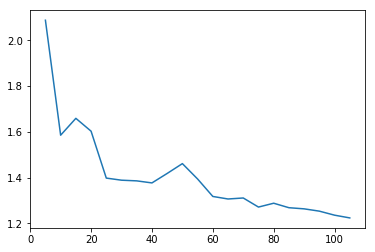

In [39]:
from sklearn.metrics import mean_squared_error

def fix(x):
    x[x > 4] = 4
    x[x < -2] = -2

START_PRED = 0
    
BATCH_SIZE = 5
steps = []
errors = []
print('stupid', mean_squared_error(pig.data[START_PRED:], [0.] * len(pig.data[START_PRED:])) ** 0.5)
for t in range(BATCH_SIZE, pig.getnnz() + 1, BATCH_SIZE):  # pig.getnnz() + 1
    steps.append(t)
    work_ids = pig.indices[:t]
    ratings = pig.data[:t]
    gpr.fit(als.VT.T[work_ids], ratings)
    y_pred, sigma = gpr.predict(als.VT.T[pig.indices[START_PRED:]], return_std=True)
    #fix(y_pred)
    rmse = mean_squared_error(pig.data[START_PRED:], y_pred) ** 0.5
    errors.append(rmse)
    print(t, 'rmse', rmse)
    eig = np.linalg.eig(gpr.L_)[0]
    print('eigenvalues', eig.min(), 'to', eig.max())
    print('alpha max', gpr.alpha_.max())
    print(y_pred[START_PRED:START_PRED+5], pig.data[START_PRED:START_PRED+5])
    #print(y_pred)
    lr.fit(als.VT.T[work_ids], ratings)
    y_pred = lr.predict(als.VT.T[pig.indices])
    rmse = mean_squared_error(pig.data, y_pred) ** 0.5
    print(t, 'rmse', rmse)
    #print(y_pred[:5], pig.data[:5])
    #print(y_pred)
    #print(pig.data)
    #print(pig.indices[y_pred > 10])
print(sigma.mean())
plt.plot(steps, errors)

In [538]:
np.round(y_pred)

array([ 2.,  2.,  2.,  3.,  3.,  1.,  2.,  1.,  3.,  1.,  1.,  3.,  2.,
        1.,  1.,  2.,  2.,  2.,  1.,  2.,  1.,  2.,  1.,  2.,  1.,  1.,
        2.,  2.,  2.,  1.,  1.,  2.,  2.,  2.,  2.,  1.,  1.,  2.,  1.,
        1.,  2.,  0.,  2.,  1.,  1.,  0.,  2.,  0.,  1.,  2.,  2.,  1.,
        1.,  1.,  0.,  1.,  2.,  0.,  1.,  2.,  2.,  3.,  0.,  1.,  3.,
        1.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  3.,  1.,  2.,  1.,  2.,
        2.,  1.,  2.,  1.,  1.,  0.,  2., -0.,  1.,  1.,  1.,  1.,  2.,
        1.,  1.])

In [539]:
gpr.alpha_

array([ 1.07184906,  0.04022235,  0.71371201,  0.25523759,  0.2755776 ,
        0.76728682,  0.76217655, -1.94969685,  0.22026026,  0.23451967,
        0.42372211,  0.2911558 , -0.10392214, -0.79069398,  0.29195661,
        1.20405003,  0.03223958,  1.41087851,  0.64202389,  0.02993513,
        0.62156393,  0.40635011, -2.87540644,  0.47079273,  0.47116849,
        0.71954528,  0.2896853 ,  0.23291098,  1.26735334,  0.52798978,
        0.56347512,  0.26409907,  0.11475331,  0.37114242,  1.35748017,
       -1.2757551 ,  0.45223012,  1.42365746,  0.64105015,  1.65769072,
       -1.78089741, -1.08545378,  1.14418226, -1.25127043,  0.78054091,
       -2.16525222, -0.12856676, -0.37838811, -0.42389455,  0.1783677 ,
        1.18937006, -1.27870629, -2.45968895, -2.73148309,  0.37844092,
        0.75314118,  0.14032453, -1.10010577,  0.77125164,  0.9642877 ,
       -0.09034189,  0.02241663, -2.39454564,  0.89969927, -0.48309111,
       -1.79386842,  0.10428374, -0.05427061, -1.98241759,  0.53

In [540]:
gpr.predict(als.VT.T[50], return_std=True)

/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(array([ 1.33883213]), array([ 0.5516606]))

In [541]:
gpr.kernel_

0.381**2 * DotProduct(sigma_0=3.51)

In [542]:
np.diag(gpr.L_)

array([ 1.7302547 ,  1.28429132,  1.22417413,  1.21022899,  1.11198289,
        1.23633752,  1.089309  ,  1.10077274,  1.06433827,  1.0599551 ,
        1.07211059,  1.04661625,  1.0804486 ,  1.06150772,  1.07176616,
        1.09608769,  1.01059015,  1.0573453 ,  1.10094186,  1.02453273,
        1.190497  ,  1.07884425,  1.05927886,  1.03839374,  1.02719981,
        1.07311452,  1.01390702,  1.06114115,  1.04119546,  1.05698057,
        1.04337259,  1.08131152,  1.02401507,  1.02698477,  1.01184781,
        1.09730126,  1.00590969,  1.07557268,  0.99957757,  1.03634646,
        1.03176825,  1.04580892,  1.00740353,  1.06421172,  1.07144213,
        1.06762813,  1.03718444,  1.06906715,  1.05031466,  1.00839463,
        1.08561337,  1.0376297 ,  1.0700753 ,  1.09108769,  1.09617029,
        1.03114669,  1.01540665,  1.03185714,  1.03831857,  1.07546105,
        1.10708092,  1.13120481,  1.122899  ,  1.03001268,  1.03752668,
        0.99529181,  1.10152653,  1.07191854,  1.07868641,  1.04

In [40]:
# Let's troubleshoot
NB_ASKED = 195
X = als.VT.T[pig.indices[:NB_ASKED]]
y = pig.data[:NB_ASKED]
X_new = als.VT.T[50]

In [41]:
np.linalg.eig(X.dot(X.T) + 1 * np.eye(19))[0]

ValueError: operands could not be broadcast together with shapes (107,107) (19,19) 

In [42]:
np.linalg.eig(kernel(X))[0]

array([  1.23315788e+02 +0.00000000e+00j,
         3.33128977e+01 +0.00000000e+00j,
         2.20909441e+01 +0.00000000e+00j,
         1.81433660e+01 +0.00000000e+00j,
         1.46025510e+01 +0.00000000e+00j,
         1.23421935e+01 +0.00000000e+00j,
         1.08824275e+01 +0.00000000e+00j,
         1.04160657e+01 +0.00000000e+00j,
         8.20645133e+00 +0.00000000e+00j,
         8.77350789e+00 +0.00000000e+00j,
         6.57686380e+00 +0.00000000e+00j,
         7.22619229e+00 +0.00000000e+00j,
         5.64851973e+00 +0.00000000e+00j,
         4.90402109e+00 +0.00000000e+00j,
         4.66061586e+00 +0.00000000e+00j,
         3.63838748e+00 +0.00000000e+00j,
         3.21855533e+00 +0.00000000e+00j,
         4.35886047e+00 +0.00000000e+00j,
         2.68242413e+00 +0.00000000e+00j,
         2.10317330e+00 +0.00000000e+00j,
         2.32854747e+00 +0.00000000e+00j,
         5.07879023e-15 +0.00000000e+00j,
        -4.01175545e-15 +0.00000000e+00j,
        -2.03394784e-15 +3.0874007

In [43]:
np.linalg.eig(gpr.kernel_(X))[0]

array([  5.98722785e+01 +0.00000000e+00j,
         2.35786083e+01 +0.00000000e+00j,
         1.57145389e+01 +0.00000000e+00j,
         1.25528284e+01 +0.00000000e+00j,
         1.03984839e+01 +0.00000000e+00j,
         8.77670335e+00 +0.00000000e+00j,
         7.74237843e+00 +0.00000000e+00j,
         7.42188546e+00 +0.00000000e+00j,
         5.85432064e+00 +0.00000000e+00j,
         6.25967049e+00 +0.00000000e+00j,
         4.68437372e+00 +0.00000000e+00j,
         5.15471318e+00 +0.00000000e+00j,
         3.99807720e+00 +0.00000000e+00j,
         3.49231597e+00 +0.00000000e+00j,
         3.32457832e+00 +0.00000000e+00j,
         2.58476645e+00 +0.00000000e+00j,
         2.29005473e+00 +0.00000000e+00j,
         3.10360173e+00 +0.00000000e+00j,
         1.91067065e+00 +0.00000000e+00j,
         1.37492837e+00 +0.00000000e+00j,
         1.66062351e+00 +0.00000000e+00j,
        -6.83137773e-16 +2.80326974e-15j,
        -6.83137773e-16 -2.80326974e-15j,
         2.99177376e-15 +1.8345778

In [44]:
pred = np.linalg.inv(kernel(X)).dot(y)
pred[:5]

array([ -3.87195417e+16,  -9.44393954e+15,  -3.24449283e+14,
        -2.05536671e+15,   2.22805197e+16])

In [45]:
pred = np.linalg.inv(gpr.kernel_(X)).dot(y)
pred[:5]  # alpha_ ?

array([ -9.00776184e+14,   7.04859989e+15,  -3.09220545e+15,
         2.80113989e+16,   3.07509970e+15])

In [46]:
gpr.alpha_

array([ 0.02192456, -1.1330316 ,  0.30881666,  1.18961261, -0.47315573,
        1.01016165,  0.89929938, -0.47966792,  1.42302979, -2.2720823 ,
        0.19379706, -0.70391942, -2.00430038, -1.06960248,  0.44560616,
       -1.5843674 , -0.45791473, -0.09612726,  0.18123813, -1.86259581,
        1.67000961,  0.40830289, -0.33707643, -0.24965643,  0.91194382,
        0.61009713,  0.89872894,  0.40374066,  1.33892564,  0.7927773 ,
        1.07171087,  0.65666636,  0.57995509,  0.92417253, -2.53046219,
       -0.98615476,  0.29785515, -0.529971  ,  0.34109105,  1.31937897,
        0.69966515,  1.44333357,  0.86014477,  1.00045741, -0.24592245,
        0.05328071,  1.35695152,  0.73107976,  0.87115887,  0.80741665,
       -2.63015085,  0.87101529, -0.38263076,  0.53977032,  0.80737743,
       -1.64028244, -0.32261891,  0.0664875 , -0.4948582 , -2.43742117,
        1.26179111, -0.93599638,  0.90709517,  0.48111416,  0.13777419,
        0.32054869,  0.24723908, -2.701845  ,  3.48504255,  0.82

In [47]:
np.linalg.norm(gpr.alpha_)

13.832075096010783

In [48]:
weights = kernel(X, X_new.reshape(1, -1))
weights

array([[ 1.85075993],
       [ 1.26111845],
       [ 1.52276992],
       [ 1.19263951],
       [ 1.22266856],
       [ 1.83007458],
       [ 0.84538205],
       [ 1.63253873],
       [ 1.64942031],
       [ 1.63836768],
       [ 1.10954731],
       [ 0.97342054],
       [ 1.09388239],
       [ 0.63122908],
       [ 0.85883243],
       [ 0.90076688],
       [ 0.95767738],
       [ 0.70180765],
       [ 0.79007913],
       [ 1.11626533],
       [ 1.05261943],
       [ 0.8651865 ],
       [ 2.36491596],
       [ 1.89869738],
       [ 0.85547318],
       [ 0.66159508],
       [ 1.09169739],
       [ 0.99078965],
       [ 1.06361789],
       [ 1.08250771],
       [ 1.04344506],
       [ 1.98530126],
       [ 3.73775149],
       [ 0.67437074],
       [ 1.36262355],
       [ 0.7586975 ],
       [ 1.04545968],
       [ 0.80606766],
       [ 1.56949458],
       [ 0.73786622],
       [ 3.59717192],
       [ 0.61697188],
       [ 1.29316193],
       [ 0.93865384],
       [ 0.71665722],
       [ 1

In [49]:
weights = gpr.kernel_(X, X_new.reshape(1, -1))
weights[:5]

array([[ 1.04914167],
       [ 0.62839226],
       [ 0.81509843],
       [ 0.57952787],
       [ 0.60095564]])

In [50]:
pred.dot(weights)

array([-43.])

In [51]:
gpr.alpha_.dot(weights)

ValueError: shapes (105,) and (107,1) not aligned: 105 (dim 0) != 107 (dim 0)

In [52]:
guilty = pig.indices[y_pred > 50]

In [53]:
guilty = pig.indices[:20]

In [54]:
Counter(pig.data[:20])

Counter({-2.2103356628975352: 2,
         -1.2103356628975352: 2,
         -0.21033566289753525: 2,
         1.7896643371024648: 11,
         2.7896643371024648: 3})

In [55]:
y_pred[y_pred > 50]

array([], dtype=float64)

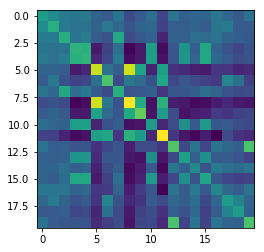

In [56]:
plt.imshow(np.cov(als.VT.T[guilty]))

In [57]:
guilty[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [58]:
gpr.kernel_

0.801**2 * DotProduct(sigma_0=0.76)

In [59]:
gpr.get_params()

{'alpha': 0.9,
 'copy_X_train': True,
 'kernel': 0.949**2 * DotProduct(sigma_0=1),
 'kernel__k1': 0.949**2,
 'kernel__k1__constant_value': 0.9,
 'kernel__k1__constant_value_bounds': (1e-05, 100000.0),
 'kernel__k2': DotProduct(sigma_0=1),
 'kernel__k2__sigma_0': 1.0,
 'kernel__k2__sigma_0_bounds': (1e-05, 100000.0),
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

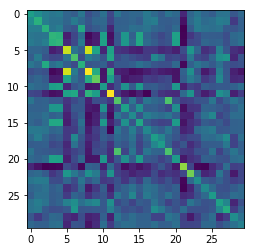

In [60]:
#np.linalg.det()
cov = np.cov(als.VT.T[pig.indices[:30]])
plt.imshow(cov)

In [61]:
cov[7, :]

array([ 0.0531541 ,  0.03905729,  0.11382829,  0.0447088 ,  0.05784416,
        0.02760635,  0.00659575,  0.12144195,  0.0167539 ,  0.0210036 ,
        0.02944408, -0.01121308,  0.0203992 ,  0.0198531 ,  0.02756664,
        0.04594382,  0.03408747,  0.01731666,  0.01083626,  0.01149602,
        0.03742922, -0.05167034,  0.02904299,  0.05177385,  0.03735967,
        0.02254538,  0.04660038,  0.01783532,  0.00906832,  0.01378673])

In [62]:
cov[1, :]

array([ 0.07967224,  0.12180739,  0.06198533,  0.04967855,  0.05004935,
        0.0341269 ,  0.057377  ,  0.03905729,  0.01743427,  0.03511715,
        0.03772754, -0.00099334,  0.0292265 ,  0.03042943,  0.03569733,
        0.02671516,  0.05521841,  0.06137909,  0.02615148,  0.02599375,
        0.02946341, -0.04375509,  0.04032839,  0.05977282,  0.04084252,
        0.04632531,  0.06241668,  0.05672471, -0.00979841,  0.02902152])

In [63]:
pig.indices[[1, 18]]

array([ 1, 18], dtype=int32)

## Linear kernel

In [65]:
from mangaki.utils.dpp2 import MangakiDPP

rated = als.VT.T[pig.indices]
dpp = MangakiDPP(vectors=rated)
dpp.compute_similarity(kernel)
dpp.preprocess()

In [66]:
dpp.sample_k(5)

array([ 15,  21,  92,  33, 104])

In [67]:
len(i_test)

415

In [68]:
all_vectors = als.VT.T[pig.indices]  # pig.indices

def bgs(nb_questions):
    global all_vectors
    rated_works = range(len(all_vectors))  # pig.getnnz()
    P = all_vectors[rated_works].dot(all_vectors[rated_works].T)
    nb_works = len(rated_works)
    # print(nb_works, nb_questions)
    kept_indices = set(range(nb_works))
    get_bgs = {}
    for _ in range(nb_works - nb_questions):
        k_min = None
        error_min = float('inf')
        for k in kept_indices:
            kept = list(kept_indices - set([k]))
            try:
                #error = np.trace(np.linalg.inv(P[np.ix_(kept, kept)]))
                #error = 1 / compute_score(kept, 'det')
                error = np.linalg.det(np.linalg.inv(P[np.ix_(kept, kept)]))
            except:
                print('I had to take', nb_questions, 'but I must stop at', len(kept_indices))
                return list(kept_indices)
            if error < error_min:
                error_min = error
                k_min = k
        kept_indices -= set([k_min])
        get_bgs[len(kept_indices)] = np.array(list(kept_indices))
    sampled_indices = list(kept_indices)
    return np.array(sampled_indices), get_bgs

In [69]:
_, get_bgs = bgs(2)

/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/numpy/linalg/linalg.py:1804: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


2 bgs rmse 1.80465406602
2 dpp rmse 1.8046537624
2 random rmse 1.98302890642
4 bgs rmse 1.85589733363
4 dpp rmse 1.85589808362
4 random rmse 1.85589828376
6 bgs rmse 1.7429056573
6 dpp rmse 1.57823278324
6 random rmse 1.67013482709
8 bgs rmse 2.0016460718
8 dpp rmse 1.46788796792
8 random rmse 1.59423865622
10 bgs rmse 1.96371846727
10 dpp rmse 2.16334333612
10 random rmse 1.82980894476
12 bgs rmse 2.10634053097
12 dpp rmse 1.90219494673
12 random rmse 1.61482900399
14 bgs rmse 2.04627298405
14 dpp rmse 1.52138737187
14 random rmse 1.67442092471
16 bgs rmse 1.92248573705
16 dpp rmse 1.65159986534
16 random rmse 1.52264897446
18 bgs rmse 1.8967301161
18 dpp rmse 1.49478794451
18 random rmse 1.48110762328
20 bgs rmse 1.72944637803
20 dpp rmse 1.41783213906
20 random rmse 1.47636549845
22 bgs rmse 1.72889736894
22 dpp rmse 1.51244697529
22 random rmse 1.6146557006
24 bgs rmse 1.70385724199
24 dpp rmse 1.53097856898
24 random rmse 1.38345321866
26 bgs rmse 1.54867324313


/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log


26 dpp rmse 1.46951036284
26 random rmse 1.60185371372
28 bgs rmse 1.60239459244
28 dpp rmse 1.52548694441
28 random rmse 1.46786144729
30 bgs rmse 1.7262194357
30 dpp rmse 1.37482659249
30 random rmse 1.77598888048
32 bgs rmse 1.79332687088
32 dpp rmse 1.32760954412
32 random rmse 1.66191327373
34 bgs rmse 1.88069280838
34 dpp rmse 1.37926385681
34 random rmse 1.43069533806
36 bgs rmse 1.81199076283
36 dpp rmse 1.3213540757
36 random rmse 1.38946072483
38 bgs rmse 1.71663281287
38 dpp rmse 1.35819910504
38 random rmse 1.48463600773
40 bgs rmse 1.71386063844
40 dpp rmse 1.46945411423
40 random rmse 1.50075640216
42 bgs rmse 1.67593068699
42 dpp rmse 1.39692618122
42 random rmse 1.35098717597
44 bgs rmse 1.56478742651


/Users/jilljenn/code/mangaki/venv/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


44 dpp rmse 1.34708746019
44 random rmse 1.28273715911
46 bgs rmse 1.57201654485
46 dpp rmse 1.39431476849
46 random rmse 1.45970878622
48 bgs rmse 1.58385241904
48 dpp rmse 1.36144033966
48 random rmse 1.31569722051
50 bgs rmse 1.62080527454
50 dpp rmse 1.34273534417
50 random rmse 1.36075875297
52 bgs rmse 1.62393800565
52 dpp rmse 1.35118049069
52 random rmse 1.32010376096
54 bgs rmse 1.59226019179
54 dpp rmse 1.31320093096
54 random rmse 1.26541837153
56 bgs rmse 1.58498757136
56 dpp rmse 1.27084501973
56 random rmse 1.2958092057
58 bgs rmse 1.61600565428
58 dpp rmse 1.35078372067
58 random rmse 1.32501311029
60 bgs rmse 1.62164300863
60 dpp rmse 1.30313981938
60 random rmse 1.30064499917
62 bgs rmse 1.60626692225
62 dpp rmse 1.28556647372
62 random rmse 1.4172641569
64 bgs rmse 1.62383735645
64 dpp rmse 1.35087478099
64 random rmse 1.3094348975
66 bgs rmse 1.5072120298
66 dpp rmse 1.27788408575
66 random rmse 1.28388236332
68 bgs rmse 1.44471530164
68 dpp rmse 1.25379787035
68 ran

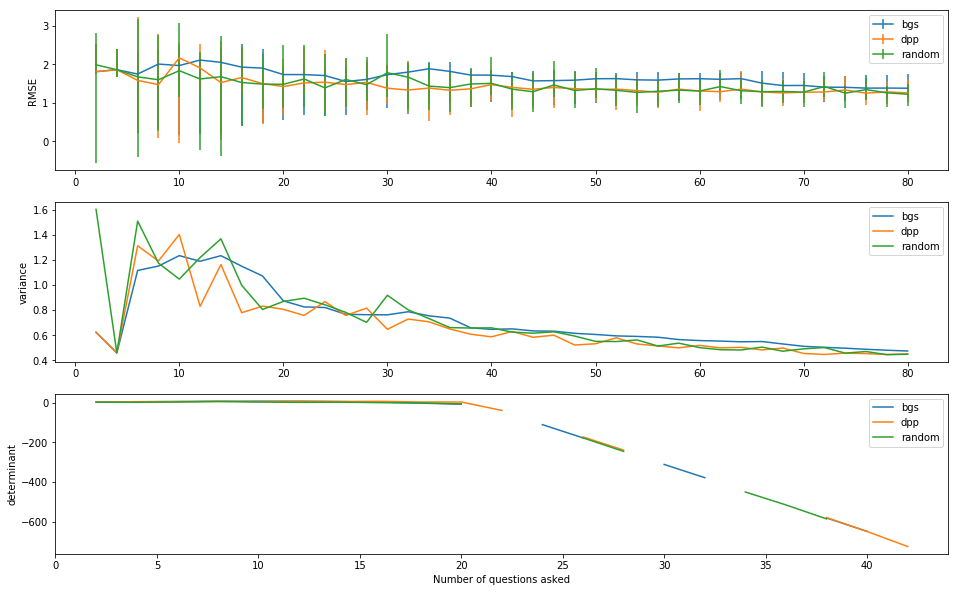

In [72]:
import random
from collections import defaultdict

fig, axes = plt.subplots(3, 1, figsize=(16, 10))
plot = {}
plot['rmse'], plot['sigma'], plot['det'] = axes

STRATEGIES = ['bgs', 'dpp', 'random'] # , ':

#gpr = GaussianProcessRegressor(kernel=0.1 * kernel)
BATCH_SIZE = 40
steps = []
values = defaultdict(lambda: defaultdict(list))
#sigmas = defaultdict(list)
#errors = defaultdict(list)
#errors_min = defaultdict(list)
#errors_max = defaultdict(list)
total_rated = pig.getnnz()
for nb_rated in list(range(2, 81, 2)):
    steps.append(nb_rated)
    for strategy in STRATEGIES:
        if strategy == 'random':
            pos = random.sample(range(total_rated), nb_rated)
        elif strategy == 'dpp':
            pos = dpp.sample_k(nb_rated)
        else:
            pos = get_bgs[nb_rated]
        work_ids = pig.indices[pos]
        ratings = pig.data[pos]
        X_asked = als.VT.T[work_ids]
        values['det'][strategy].append(np.log(np.linalg.det(kernel(X_asked))))
        
        gpr.fit(X_asked, ratings)
        y_pred, sigma = gpr.predict(als.VT.T[pig.indices], return_std=True)
        fix(y_pred)
        rmse = mean_squared_error(pig.data, y_pred) ** 0.5
        rmse_up = abs(rmse - mean_squared_error(pig.data, y_pred + 1.96 * sigma) ** 0.5)
        rmse_down = abs(rmse - mean_squared_error(pig.data, y_pred - 1.96 * sigma) ** 0.5)
        values['sigma'][strategy].append(sigma.mean())
        values['rmse'][strategy].append(rmse)
        values['rmse_up'][strategy].append(rmse_up)
        values['rmse_down'][strategy].append(rmse_down)
        print(nb_rated, strategy, 'rmse', rmse)
        #print(y_pred[:5], pig.data[:5])
curves = defaultdict(list)
#sigma_curves = []
for strategy in STRATEGIES:
    for value in ['sigma', 'det']:
        curves[value].append(plot[value].errorbar(steps, values[value][strategy], label=strategy))
    curves['rmse'].append(plot['rmse'].errorbar(steps, values['rmse'][strategy],
                                                yerr=[values['rmse_down'][strategy], values['rmse_up'][strategy]],
                                                label=strategy))
for value in ['rmse', 'sigma', 'det']:
    plot[value].legend(handles=curves[value])
plt.xlabel('Number of questions asked')
plot['rmse'].set_ylabel('RMSE')
plot['det'].set_ylabel('determinant')
plot['sigma'].set_ylabel('variance')
plt.show()

In [104]:
nb_rated = 15
rand_ids = random.sample(range(total_rated), nb_rated)
bgs_ids = get_bgs[nb_rated]
dpp_ids = dpp.sample_k(nb_rated)

1.01319837277e-20 1.77006292843


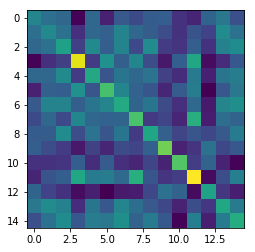

5.07643930341e-19 1.65619298621


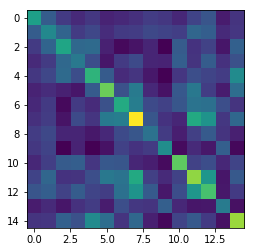

5.32166853508e-18 2.08200409715


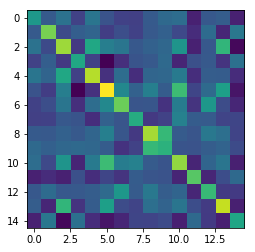

In [105]:
for pos in [rand_ids, bgs_ids, dpp_ids]:
    cov = np.cov(als.VT.T[pig.indices[pos]])
    plt.imshow(cov)
    print(np.linalg.det(cov), np.trace(cov))
    plt.show()

## RBF kernel

In [73]:
from sklearn.gaussian_process.kernels import RBF

In [74]:
rated = als.VT.T[pig.indices]
rbf = RBF()
dpprbf = MangakiDPP(vectors=rated)
dpprbf.L = rbf(dpprbf.vectors)
dpprbf.preprocess()

5 random rmse 1.62780164887
[ 1.44104639  1.55033494  1.41606993  2.78966434  2.64359267] [ 1.78966434  1.78966434  2.78966434  2.78966434  1.78966434]
5 dpp rmse 1.68166800017
[ 0.45476035  0.42948055  0.46961632  0.22468041  0.21667369] [ 1.78966434  1.78966434  2.78966434  2.78966434  1.78966434]
5 bgs rmse 1.63146627546
[ 0.33725783  0.40444808  0.98263677  0.34368167  0.40565303] [ 1.78966434  1.78966434  2.78966434  2.78966434  1.78966434]
10 random rmse 1.65297511884
[ 1.36620645  1.21321005  1.6768777  -0.1793142  -0.03934739] [ 1.78966434  1.78966434  2.78966434  2.78966434  1.78966434]
10 dpp rmse 1.46822697402
[ 1.18027129  1.6645525   1.36421709  1.55840062  1.65847299] [ 1.78966434  1.78966434  2.78966434  2.78966434  1.78966434]
10 bgs rmse 2.00879803832
[-0.53851842 -0.50523959  0.59036009 -0.14889553 -0.13956204] [ 1.78966434  1.78966434  2.78966434  2.78966434  1.78966434]
20 random rmse 1.36201771848
[ 1.78966434  1.37396847  1.67129652  0.854122    0.97524165] [ 1.78

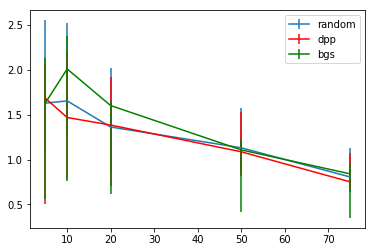

In [78]:
import random
from collections import defaultdict

kernel = DotProduct()
gpr = GaussianProcessRegressor()
BATCH_SIZE = 40
steps = []
errors = defaultdict(list)
errors_min = defaultdict(list)
errors_max = defaultdict(list)
total_rated = pig.getnnz()
for nb_rated in [5, 10, 20, 50, 75]:
    steps.append(nb_rated)
    for strategy in ['random', 'dpp', 'bgs']:
        if strategy == 'random':
            pos = random.sample(range(total_rated), nb_rated)
        elif strategy == 'dpp':
            pos = dpprbf.sample_k(nb_rated)
        elif strategy == 'bgs':
            pos = get_bgs[nb_rated]
        work_ids = pig.indices[pos]
        ratings = pig.data[pos]
        
        gpr.fit(als.VT.T[work_ids], ratings)
        y_pred, sigma = gpr.predict(als.VT.T[pig.indices], return_std=True)
        rmse = mean_squared_error(pig.data, y_pred) ** 0.5
        rmse_max = mean_squared_error(pig.data, y_pred + 1.96 * sigma) ** 0.5
        rmse_min = mean_squared_error(pig.data, y_pred - 1.96 * sigma) ** 0.5
        errors[strategy].append(rmse)
        errors_max[strategy].append(abs(rmse_max - rmse))
        errors_min[strategy].append(abs(rmse_min - rmse))
        print(nb_rated, strategy, 'rmse', rmse)
        print(y_pred[:5], pig.data[:5])
rand_curve = plt.errorbar(steps, errors['random'], yerr=[errors_min['random'], errors_max['random']], label='random')
dpp_curve = plt.errorbar(steps, errors['dpp'], yerr=[errors_min['dpp'], errors_max['dpp']], color='r', label='dpp')
bgs_curve = plt.errorbar(steps, errors['bgs'], yerr=[errors_min['bgs'], errors_max['bgs']], color='g', label='bgs')

plt.legend(handles=[rand_curve, dpp_curve, bgs_curve])
plt.show()

In [201]:
X = np.random.random((5, 2))*100
eig, _ = np.linalg.eig(X.dot(X.T))

In [204]:
np.round(eig)

array([ 18630.,     -0.,   3416.,      0.,     -0.])